In [1]:
import matplotlib.pyplot as plt
plt.style.use("nature_neurosci.mplstyle")


# Define colors
colors = {
    "Single": "#333333",
    "Left": "#2C7BB6",
    "Right": "#D7191C",
    "Ipsilateral": "#4477AA",
    "Contralateral": "#BB5544",
    "Within": "#1f3a63ff",
    "Across": "#e89d0bff"
}

from matplotlib.colors import LinearSegmentedColormap
left_right_cmap = LinearSegmentedColormap.from_list("LeftRight",\
                                                     [colors['Left'], "white", colors['Right']])
ipsi_contra_cmap = LinearSegmentedColormap.from_list("IpsiContra",\
                                                     [colors['Ipsilateral'], "white", colors['Contralateral']])

In [2]:
## circstats
def len2(x):
	if type(x) is not type([]):
		if type(x) is not type(array([])):
			return -1
	return len(x)

def phase2(x):
	if not np.isnan(x):
		return phase(x)
	return nan
    
def circdist(angles1,angles2):
    ''' calculates circular distance of angles [rad]'''
    if len2(angles2) < 0:
        if len2(angles1) > 0:
            angles2 = [angles2]*len(angles1)
        else:
            angles2 = [angles2]
            angles1 = [angles1]
        if len2(angles1) < 0:
            angles1 = [angles1]*len(angles2)
    return array(list(map(lambda a1,a2: phase2(np.exp(1j*a1)/np.exp(1j*a2)), angles1,angles2)))

In [3]:
def sig_bar(sigs,axis,y,ax,color):
	w=np.diff(axis)[0]
	for s in sigs:
		beg =axis[s]-w/2
		end = axis[s]+w/2
		ax.fill_between([beg,end],[y[0],y[0]],[y[1],y[1]],color=color)

In [4]:
def sign_rl(rel_loc):
    # returns sign of array unless value=0, returns 1
    sign = [np.sign(rel_loc[rl]) if rel_loc[rl]!=0.0 else 1 for rl in range(len(rel_loc))]
    return np.array(sign)

# LOAD DATA

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from scipy.io import loadmat
from scipy.stats import *
from scipy.optimize import curve_fit
from cmath import phase
from numpy import array
from scipy.sparse import csr_matrix
import urllib
import pickle
from scipy.io import loadmat
import glob
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
#from pymicro.view.vol_utils import compute_affine_transform
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
import statsmodels.formula.api as sf
from sklearn import metrics
from random import randint
from numpy.linalg import inv
import math
import io
#import h5py
from circ_stats import *
from patsy import dmatrices
import statsmodels.api as sm
import helpers as hf
import statsmodels.formula.api as smf
import copy
import matplotlib.ticker as ticker
from pingouin import circ_corrcc


#monkeys = ["Sa", "Pe", "Wa"]
#for m in monkeys:
#    files = np.sort(glob.glob('../Data/new/%s*.mat' %m))
#    for f in files:
#        print(f)

monkeys=['Sa', 'Pe', 'Wa']

with open('./Results/df_serial.pickle', 'rb') as handle:
    df_sb = pickle.load(handle)
df_sb = df_sb.reset_index()
df_sb.rel_loc = np.round(df_sb.rel_loc,3)

    
#df_behav = df_behav.loc[(df_behav.monkey=='Sa') | (df_behav.monkey=='Wa')].reset_index(drop=True)
df_sb['session_continuous'] = [df_sb.monkey[i]+str(df_sb.session[i]) for i in df_sb.index]

same_id = 1
opp_id = 0
border_id = 2

# colors for accuracy plots
cmap_ACC = matplotlib.cm.get_cmap('summer_r')
colors_ACC = [cmap_ACC(0.1+i/(3+1)) for i in range(3)]

# colors for delay dependence plots
cmap_delay = matplotlib.cm.get_cmap('binary_r')
colors_delay = [cmap_delay(i/(4+0.1)) for i in range(4)]

# colors for serial dependence plots
# cmap_SD = matplotlib.cm.get_cmap('Oranges_r')
# colors_SD = [cmap_SD(0.1+i/(3+1)) for i in range(3)]
colors_SD = ['#054E3A', '#43AA8B', '#859F98']

cmap = matplotlib.cm.get_cmap('binary_r')
colors_mono_bw = [cmap((m+1)/3.8) for m in range(3)]

# colors for same vs opposite hemisphere
colors_so = {'within': 'darkgreen', 'across': 'darkorange'}

cmap = matplotlib.cm.get_cmap('PiYG')
color1=cmap(230)#'#751A5D'#'#873145'
color2=cmap(40)#'#0C7C59'#'#2A7979'
colors_ic={'ipsi':color2, 'contra':color1}

# DEFINE DOG FIT PARAMETERS FOR EACH ANIMAL (based on BIC, questionable for Pe, Wa (delta BIC <2)
sigma={'Sa':0.9, 'Pe':2.15, 'Wa':0.45}
neural_sigma = {'Sa': 1.35, 'Pe': 3.0, 'Wa': 1.75}#
reactivation_sigma={'Sa':2.6, 'Pe':1.45, 'Wa':1.35}

In [6]:
df_sb.keys()

Index(['index', 'trial_id', 'target_prev', 'target_xy_prev', 'response_prev',
       'response_prev_uncorrected', 'err_prev', 'err_prev_uncorrected',
       'response_xy_prev', 'response_xy_prev_uncorrected', 'delay_prev',
       'target_curr', 'target_xy_curr', 'response_curr',
       'response_curr_uncorrected', 'response_xy_curr',
       'response_xy_curr_uncorrected', 'err', 'err_uncorrected', 'rel_loc',
       'delay_curr', 'ITI', 'broke', 'hemifield_prev', 'hemifield_curr',
       'topdown_prev', 'topdown_curr', 'monkey', 'session', 'num_targ',
       'session_continuous'],
      dtype='object')

/home/melanie/anaconda3/envs/brian2/lib/python3.6/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.4.0, the latest is 0.5.5.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


----

# General information

In [7]:
for targ in [4, 8, 16]:
    print('Targets = '+str(targ)+', '+\
          str(len(df_sb[df_sb.num_targ==targ].session_continuous.unique()))+' sessions, '+\
         str(len(df_sb[df_sb.num_targ==targ]))+' trials.')


Targets = 4, 7 sessions, 3453 trials.
Targets = 8, 12 sessions, 5666 trials.
Targets = 16, 22 sessions, 9065 trials.


# Fig 1: Accuracy

### Fig 1d: delay dependence of accuracy

In [8]:
# use 8 targets
# only use 8 targets in specific locaton to get clean plot
sess0 = df_sb.loc[(df_sb.monkey=='Sa') & (df_sb.session==5)]
target_tuples = [tuple(np.round(sess0.target_xy_curr[i],0)) for i in sess0.index]
chosen_targs = list(set(target_tuples))

# define colors (need offset, otherwise one color is white)
target_colors = [cmap_ACC(-0.45+i/(len(chosen_targs)-2)) for i in range(len(chosen_targs))]
# left from bottom to top, borders, right from bottom to top
target_hue_order = [ 1.5708, -1.5708, -0.7854 ,  0.     , 0.7854,  -2.35619, 3.14159, 2.35619]
# set border trial colors to grey
target_colors[0] = 'grey'
target_colors[1] = 'grey'

# convert coordinates to tuples
df_sb['targ_curr_tuple'] = [tuple(np.round(df_sb.target_xy_curr[i],0))\
                                         for i in df_sb.index]

# only use trials with targets in the chosen locations
df_chosen = df_sb.loc[np.where([(df_sb.targ_curr_tuple[i] in chosen_targs)\
                                             for i in df_sb.index])[0]].copy().reset_index()

Delay lengths split based on quartile delays = 1820.0s, 2320.0s.


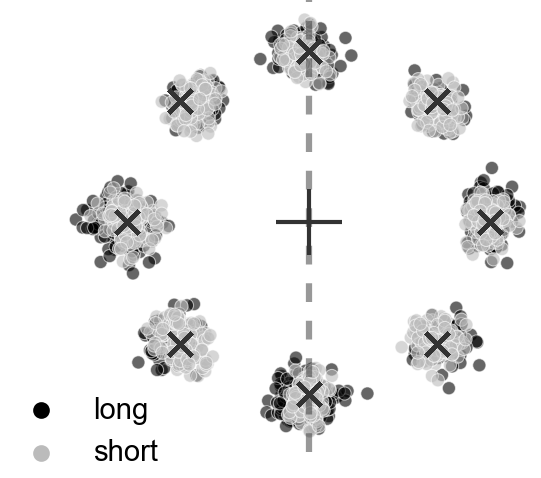

In [10]:
df_chosen['response_x_uncorrected'] = [df_chosen.response_xy_curr_uncorrected[i][0] for i in df_chosen.index]
df_chosen['response_y_uncorrected'] = [df_chosen.response_xy_curr_uncorrected[i][1] for i in df_chosen.index]

print('Delay lengths split based on quartile delays = '+str(np.percentile(df_chosen.delay_curr, 25))+'s, '+\
     str(np.percentile(df_chosen.delay_curr, 75))+'s.')
df_chosen['delay'] = ['long' if delay > np.percentile(df_chosen.delay_curr, 75)\
                        else 'short' if delay < np.percentile(df_chosen.delay_curr, 25)\
                      else 'middle half' for delay in df_chosen.delay_curr.values]

df_longshortquart = df_chosen.drop(index = np.where(df_chosen.delay == 'middle half')[0])
delay_hue_order = ['long', 'short']
delay_colors = [colors_delay[0], colors_delay[3]]

test = df_longshortquart.copy()
test = test.sort_values('delay', key=np.vectorize(delay_hue_order.index))

# plot the figure
f, ax = plt.subplots(figsize=(2.1,2))
plt.scatter(0, 0, color='#333333', marker='+', s=250)
plt.axvline(0, color='#333333', dashes=[3,3], alpha=0.5, linewidth=1.5)
# plot responses
g = sns.scatterplot(data=test, x='response_x_uncorrected', y='response_y_uncorrected', hue='delay',\
                palette=delay_colors, hue_order = delay_hue_order, alpha=0.6, s=10)
g.legend_.set_title(None)
g.legend(bbox_to_anchor=(-0.11, 0.15), loc='upper left', borderaxespad=0)
# plot targets
plt.scatter([df_longshortquart.target_xy_curr[i][0] for i in df_longshortquart.index],\
               [df_longshortquart.target_xy_curr[i][1] for i in df_longshortquart.index], color='#333333', marker='x', s=30)

sns.despine(left=True, bottom=True)
plt.xlabel('')
plt.ylabel('')
plt.xticks([])
plt.yticks([])
#plt.savefig('./Figures/Figure1/DelayDistributedAccuracy.svg', bbox_inches='tight', pad_inches=0)
plt.show()

### Fig 1e

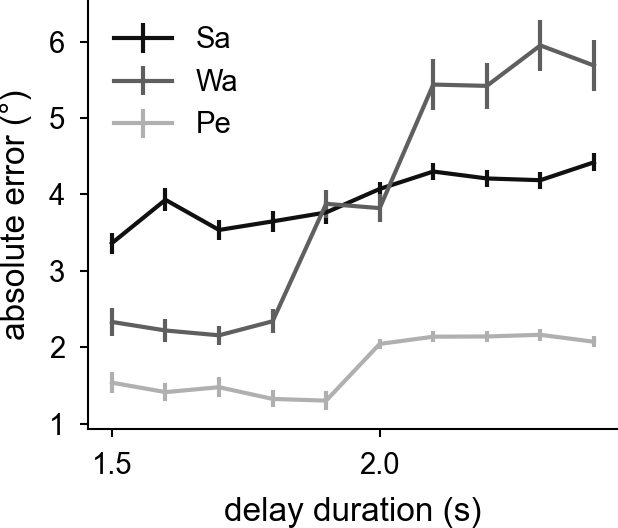

In [11]:
cmap = matplotlib.cm.get_cmap('binary_r')
colors_mono_bw = [cmap((m+0.2)/3.2) for m in range(3)]

df_helper = df_sb.copy()

df_helper['delay_prev_int'] = np.round(df_helper.delay_prev/1000, 1)
df_helper['abs_err'] = np.abs(df_helper.err)

f,ax = plt.subplots(1,1, figsize=(2.3,2))
for m, monkey in enumerate(['Sa', 'Wa', 'Pe']):
    df_mono = df_helper.loc[df_helper.monkey==monkey]
    
    # group by delay length
    delay_group = df_mono.groupby('delay_prev_int')
    keys = np.array(list(delay_group.groups.keys()))
    
    # delays smaller 2.5s (afterwards STD goes up)
    index = np.where(keys<2.5)[0]
    
    #plt.scatter(df_mono.delay_prev_int, df_mono.abs_err, alpha=0.03, color=colors_mono_bw[m])
    
    plt.errorbar(keys[index], np.rad2deg(delay_group.abs_err.mean().values[index]),\
                 yerr=np.rad2deg(delay_group.abs_err.sem().values[index]), color=colors_mono_bw[m], label=monkey)
    
ax.set_xlabel('delay duration (s)')
ax.set_xticks([1.5, 2])
ax.set_ylabel('absolute error (°)')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
plt.legend()
plt.tight_layout()
sns.despine()
#plt.savefig('./Figures/Figure1/DelayAccuracyReduction_Lineplot_smaller25s.svg')
plt.show()

Linear model across sessions (not mixed, since each session only has a 0.5s delay)

### Statistics Fig. 1e

In [12]:
df_sb['err_deg'] = np.rad2deg(df_sb.err)
df_sb['abs_err_deg'] = np.abs(df_sb.err_deg)
df_sb['delay_inSecs'] = np.round(df_sb.delay_curr/1000,1)

# group model
for m,mono in enumerate(monkeys): # enumerate(['Sa']):#
    df_mono = df_sb.loc[df_sb.monkey==mono].copy()
    M = smf.ols(formula='abs_err_deg~delay_inSecs',\
                    data=df_mono).fit()
    print('################ Group model '+mono+' ###############')
    print(M.summary())
    
    print(M.pvalues)


################ Group model Sa ###############
                            OLS Regression Results                            
Dep. Variable:            abs_err_deg   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     39.81
Date:                Thu, 03 Jul 2025   Prob (F-statistic):           2.95e-10
Time:                        13:31:37   Log-Likelihood:                -20553.
No. Observations:                7904   AIC:                         4.111e+04
Df Residuals:                    7902   BIC:                         4.112e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------


---

# Fig. 1f: Serial dependence

/home/melanie/anaconda3/envs/brian2/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/melanie/anaconda3/envs/brian2/lib/python3.6/site-packages/statsmodels/regression/mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  ConvergenceWarning)
/home/melanie/anaconda3/envs/brian2/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/melanie/anaconda3/envs/brian2/lib/python3.6/site-packages/statsmodels/regression/mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with cg
  ConvergenceWarning)
/home/melanie/anaconda3/envs/brian2/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  Conver

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: err      
No. Observations: 7904    Method:             REML     
No. Groups:       16      Scale:              0.0077   
Min. group size:  159     Log-Likelihood:     7962.4247
Max. group size:  882     Converged:          No       
Mean group size:  494.0                                
-------------------------------------------------------
             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept    -0.001    0.021 -0.039 0.969 -0.041  0.040
DoG_fit       0.042    0.002 24.723 0.000  0.039  0.045
Group Var     0.007                                    

Intercept     9.687596e-01
DoG_fit      6.019279e-135
Group Var              NaN
dtype: float64


/home/melanie/anaconda3/envs/brian2/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/melanie/anaconda3/envs/brian2/lib/python3.6/site-packages/statsmodels/regression/mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  ConvergenceWarning)
/home/melanie/anaconda3/envs/brian2/lib/python3.6/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/home/melanie/anaconda3/envs/brian2/lib/python3.6/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/melanie/anaconda3/envs/brian2/lib/python3.6/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parame

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: err      
No. Observations: 2646    Method:             REML     
No. Groups:       9       Scale:              0.0095   
Min. group size:  192     Log-Likelihood:     2399.7679
Max. group size:  608     Converged:          Yes      
Mean group size:  294.0                                
--------------------------------------------------------
           Coef.  Std.Err.    z    P>|z|  [0.025  0.975]
--------------------------------------------------------
Intercept  0.001     0.001  0.914  0.361  -0.001   0.004
DoG_fit    0.011     0.006  1.913  0.056  -0.000   0.023
Group Var  0.000                                        

Intercept    0.360835
DoG_fit      0.055740
Group Var         NaN
dtype: float64


/home/melanie/anaconda3/envs/brian2/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/melanie/anaconda3/envs/brian2/lib/python3.6/site-packages/statsmodels/regression/mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  ConvergenceWarning)
/home/melanie/anaconda3/envs/brian2/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/melanie/anaconda3/envs/brian2/lib/python3.6/site-packages/statsmodels/regression/mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with cg
  ConvergenceWarning)


         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: err       
No. Observations: 7634    Method:             REML      
No. Groups:       16      Scale:              0.0028    
Min. group size:  312     Log-Likelihood:     11534.4107
Max. group size:  784     Converged:          No        
Mean group size:  477.1                                 
--------------------------------------------------------
              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept     -0.001    0.001 -2.000 0.045 -0.002 -0.000
DoG_fit        0.001    0.001  1.404 0.160 -0.000  0.002
Group Var      0.000                                    

Intercept    0.045473
DoG_fit      0.160294
Group Var         NaN
dtype: float64


/home/melanie/anaconda3/envs/brian2/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/melanie/anaconda3/envs/brian2/lib/python3.6/site-packages/statsmodels/regression/mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
/home/melanie/anaconda3/envs/brian2/lib/python3.6/site-packages/statsmodels/regression/mixed_linear_model.py:2218: ConvergenceWarning: Gradient optimization failed, |grad| = 12.660660
  warnings.warn(msg, ConvergenceWarning)
/home/melanie/anaconda3/envs/brian2/lib/python3.6/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/melanie/anaconda3/envs/brian2/lib/python3.6/site-packages/statsmodels/regression/mixed_

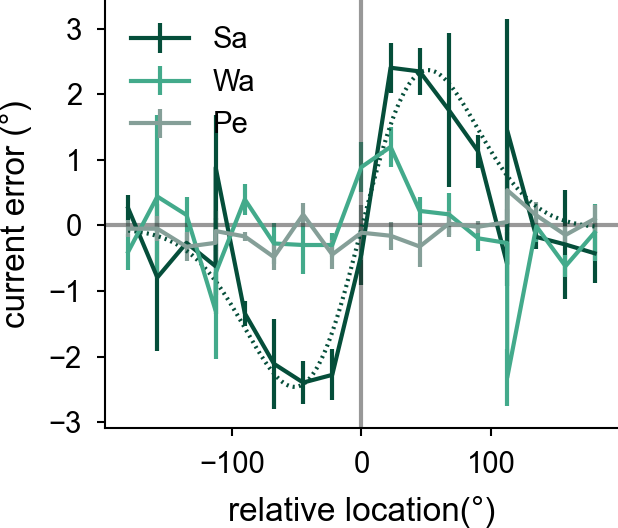

In [13]:
monkeys = ['Sa', 'Pe', 'Wa']
df_sb['rel_loc_roll'] = np.roll(df_sb.rel_loc,1)
df_sb['err_deg_uncorrected'] = np.rad2deg(df_sb.err_uncorrected)

fig,ax = plt.subplots(1,1,figsize=(2.3, 2))
plt.axhline(color='#333333', alpha=0.5, linewidth=1)
plt.axvline(color='#333333', alpha=0.5, linewidth=1)

targets = np.unique(df_sb.rel_loc)

for m,mono in enumerate(['Sa', 'Wa', 'Pe']): # enumerate(['Sa']):#
    df_mono = df_sb.loc[df_sb.monkey==mono].copy()
    sb_session = np.empty((len(np.unique(df_mono.session)),len(targets)))
    for sess in np.unique(df_mono.session):
        df_sess = df_mono.loc[df_mono.session == sess]
        for t_id,t in enumerate(targets):
            sb_session[int(sess),t_id] = circmean(df_sess.loc[df_sess.rel_loc==t].err, low=-np.pi, high=np.pi)
            #except:
            #    sb_session[t_id] = np.nan
    ax.errorbar(np.rad2deg(targets),np.rad2deg(np.nanmean(sb_session, axis=0)),\
                yerr = np.rad2deg(sem(sb_session, axis=0, nan_policy='omit')),  color=colors_SD[m], label=mono)

    ax.spines['right'].set_visible(False)
    
    # fit model
    xx = np.linspace(-np.pi, np.pi, 1000)
    df_mono['DoG_fit'] = -hf.dog1(sigma[mono],df_mono.rel_loc)
    #M = smf.mixedlm(formula='err~DoG_fit', data=df_mono,\
    #               groups = df_mono['session']).fit()
    M = smf.mixedlm(formula='err~DoG_fit', data=df_mono, groups=df_mono['session']).fit()
    print(M.summary())
    print(M.pvalues)
    if mono=='Sa':
        plt.plot(np.rad2deg(xx),\
                 np.rad2deg(M.params['Intercept']+M.params['DoG_fit']*-hf.dog1(sigma[mono], xx)),\
                 color=colors_SD[m], dashes=[0.5,1])


ax.spines['top'].set_visible(False)
plt.xlabel('relative location(°)')
plt.ylabel('current error (°)')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
plt.legend()
plt.tight_layout()
# plt.savefig('./Figures/Figure1/SerialBiasSaPeWa.svg')
plt.show()

## Fig 1g: Delay dependent SD

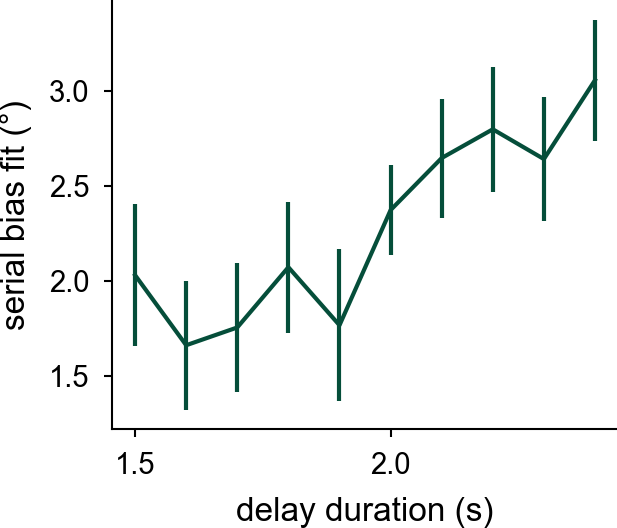

In [14]:
fig,ax = plt.subplots(1,1,figsize=(2.3,2))
#ax.axhline(color='#333333', linewidth=1, alpha=0.5)
    
for m,monkey in enumerate(['Sa']):#enumerate(monkeys):
    df_mono = df_sb.loc[df_sb.monkey==monkey].copy()
    df_mono['delay_curr_round'] = np.round(df_mono.delay_curr/1000,1)

    # choose what to split by
    chosen_factor = 'delay_curr_round'#'ITI'#'delay_curr'#'trial_id'#
    
    dog_fits = {d: np.nan for d in np.unique(df_mono[chosen_factor])}
    dog_fits_sem = {d: np.nan for d in np.unique(df_mono[chosen_factor])}
    dog_fits_p = {d: np.nan for d in np.unique(df_mono[chosen_factor])}
    # for each delay compute the serial dependence strength
    for idx_delay,(delay_i, df_delay) in enumerate(df_mono.groupby(chosen_factor)):
        df_delay['DoG_fit'] = -hf.dog1(sigma[monkey], df_delay.rel_loc.values)
        M = smf.ols("err ~ DoG_fit", data = df_delay).fit()
        dog_fits[delay_i] = M.params['DoG_fit']
        dog_fits_sem[delay_i] = M.bse['DoG_fit']
        dog_fits_p[delay_i] = M.pvalues['DoG_fit']

    delays = np.array(list(dog_fits.keys()))
    chosendelays = np.where(delays < 2.5)[0]
    delays = delays[chosendelays]
    fits = np.array(list(dog_fits.values()))[chosendelays]
    SEM = np.array(list(dog_fits_sem.values()))[chosendelays]
    pvals = np.array(list(dog_fits_p.values()))[chosendelays]
    ax.errorbar(delays, np.rad2deg(fits), \
                yerr = np.rad2deg(SEM),\
                color=colors_SD[m], label=monkey)
    nonsig = np.where(pvals>0.05)[0]
    ax.scatter(delays[nonsig], np.rad2deg(fits)[nonsig], marker='o', color='grey')

ax.set_xticks([1.5, 2.])
ax.set_xlabel('delay duration (s)')
ax.set_ylabel('serial bias fit (°)')
#plt.legend()
#plt.ylim([-1.75,4.25])
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
plt.tight_layout()
sns.despine()
#plt.savefig('./Figures/Figure1/DelaySerialBias_timeresolved.svg')
plt.show()


In [19]:
for monkey in monkeys:
    df_mono = df_sb.loc[df_sb.monkey==monkey].copy()
    df_mono['delay_curr_round'] = np.round(df_mono.delay_curr/1000,1)
    targets = np.unique(df_mono.loc[df_mono.session==0].rel_loc)#np.unique(df_mono.rel_loc)

    df_mono['DoG_fit'] = -hf.dog1(sigma[monkey], df_mono.rel_loc)
    M = smf.ols('err ~ DoG_fit*'+chosen_factor, data = df_mono).fit()
    print(monkey+' parameters in (°): \n'+str(np.rad2deg(M.params))+'\n')
    print(monkey+' p-values: \n'+str(M.pvalues)+'\n')
    #print(M.summary())

Sa parameters in (°): 
Intercept                  -0.286284
DoG_fit                     0.276316
delay_curr_round            0.104184
DoG_fit:delay_curr_round    1.028506
dtype: float64

Sa p-values: 
Intercept                   0.472869
DoG_fit                     0.677695
delay_curr_round            0.578214
DoG_fit:delay_curr_round    0.001109
dtype: float64

Pe parameters in (°): 
Intercept                   0.168341
DoG_fit                    -0.412368
delay_curr_round           -0.109252
DoG_fit:delay_curr_round    0.215768
dtype: float64

Pe p-values: 
Intercept                   0.585458
DoG_fit                     0.266072
delay_curr_round            0.438181
DoG_fit:delay_curr_round    0.201773
dtype: float64

Wa parameters in (°): 
Intercept                   0.495170
DoG_fit                     0.555018
delay_curr_round           -0.279136
DoG_fit:delay_curr_round    0.056733
dtype: float64

Wa p-values: 
Intercept                   0.538985
DoG_fit                     0.85

---